# Verification experiment - NARMAX

I generate data according to a NARMAX model and recover parameters using both a FEM estimator and an RLS estimator. 

The estimators are validated with a simulation error experiment.

In [1]:
using Revise
using ProgressMeter
using LinearAlgebra
using Plots
pyplot();

## Data generation

#### Experimental parameters

In [2]:
# Orders
M1 = 2
M2 = 2
M3 = 2
M = M1+1+M2+M3

# Number of coefficients
deg_t = 3
N_t = (M1+1+M2+M3)*deg_t + 1

# Parameters
τ_true = 1e4
θ_true = .5 .*(rand(N_t,) .- 0.5)
θ_true[end] = 0.

# Length of transient period
tt = 50

# Length of observed signal
ts = 100 + tt

# Length of simulation horizon
T = 1000 + ts;

#### Generate input

In [3]:
include("fMultiSinGen.jl")

# Parameters
num_periods = 400
points_period = 100
num_real = 1
fMin = 0.0
fMax = 10.0
fs = 100.
f0 = fs/points_period
linesMin = ceil(fMin/f0)+1;
linesMax = floor(fMax/f0)+1;

# Input frequency and amplitude
input, inputfreq = fMultiSinGen(points_period, 
                                num_periods, 
                                num_real, 
                                fMin=fMin, 
                                fMax=fMax, 
                                fs=fs, 
                                type_signal="odd", 
                                uStd=0.1);

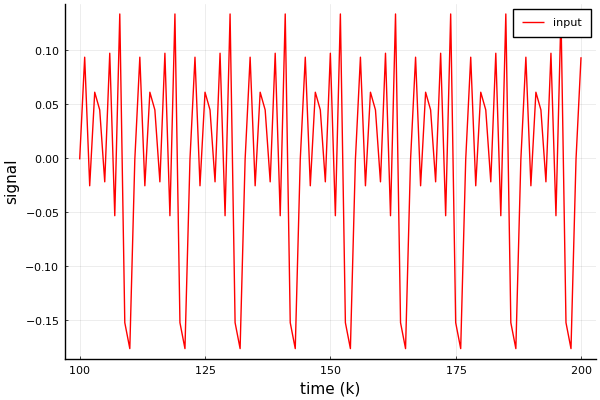

In [32]:
ix_zoom = 100:200
plot(ix_zoom, input[ix_zoom], color="red", label="input", xlabel="time (k)", ylabel="signal")

In [33]:
savefig("figures/generated-input_zoom100-200.png")

#### Generate output

In [6]:
# True basis function
PΨ = zeros(M,1); for d=1:deg_t; PΨ = hcat(d .*Matrix{Float64}(I,M,M), PΨ); end
ψ(x::Array{Float64,1}) = [prod(x.^PΨ[:,k]) for k = 1:size(PΨ,2)]

# Observation array
output = zeros(T,)
errors = zeros(T,)

for k = 1:T

    # Generate noise
    errors[k] = sqrt(inv(τ_true))*randn(1)[1]

    # Output
    if k < (maximum([M1,M2,M3])+1)
        output[k] = input[k] + errors[k]
    else
        # Update history vectors
        z_kmin1 = input[k-1:-1:k-M2]
        x_kmin1 = output[k-1:-1:k-M1]
        r_kmin1 = errors[k-1:-1:k-M3]

        # Compute output
        output[k] = θ_true'*ψ([x_kmin1; input[k]; z_kmin1; r_kmin1]) + errors[k]
    end
end

# Y-Limits of output signal
ylims = [minimum(output[tt:T]), maximum(output[tt:T])];

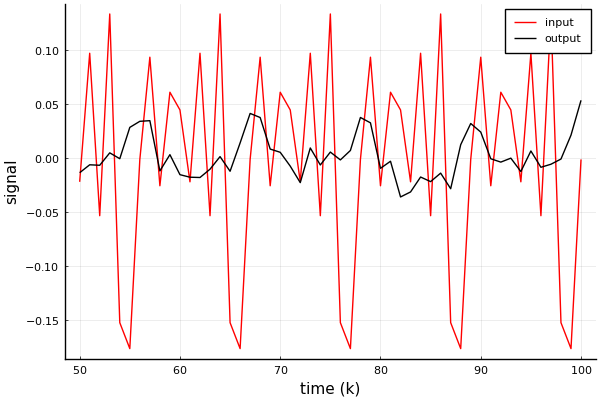

In [34]:
# Visualize signal
if T > 100
    plot(tt:100, input[tt:100], color="red", label="input", xlabel="time (k)", ylabel="signal")
    plot!(tt:100, output[tt:100], color="black", label="output", xlabel="time (k)", ylabel="signal")
else 
    plot(tt:T, input[tt:T], color="red", label="input", xlabel="time (k)", ylabel="signal")
    plot!(tt:T, output[tt:T], color="black", label="output", xlabel="time (k)", ylabel="signal")
end

In [35]:
savefig("figures/generated-input+output_zoom50-100.png")

## Model specification

In [8]:
using ForneyLab
import ForneyLab: unsafeMean, unsafeCov, unsafeMeanCov

In [9]:
using NARMAX

In [10]:
graph = FactorGraph()

# Degree of model
deg_m = 3
N_m = (M1+1+M2+M3)*deg_m + 1

# Model basis function
PΦ = zeros(M,1); for d=1:deg_m; PΦ = hcat(d .*Matrix{Float64}(I,M,M), PΦ); end
ϕ(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)]

# Observed variables
@RV x_kmin1; placeholder(x_kmin1, :x_kmin1, dims=(M1,))
@RV z_kmin1; placeholder(z_kmin1, :z_kmin1, dims=(M2,))
@RV r_kmin1; placeholder(r_kmin1, :r_kmin1, dims=(M3,))
@RV u_k; placeholder(u_k, :u_k)

# Time-invariant parameters
@RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
@RV θ ~ GaussianMeanVariance(placeholder(:m_θ, dims=(N_m,)), placeholder(:v_θ, dims=(N_m, N_m)))

# Likel7ihood
@RV y_k ~ NAutoRegressiveMovingAverageX(θ, x_kmin1, u_k, z_kmin1, r_kmin1, τ, g=ϕ)
placeholder(y_k, :y_k)

ForneyLab.draw(graph)

# Compile message passing procedure
q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
algorithm = messagePassingAlgorithm([θ; τ], q)
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 18178047386823853889 -->
 
 18178047386823853889 
 
 placeholder_v_θ 
 
<!-- 12339560568787385562 -->
 
 12339560568787385562 
 
 placeholder_y_k 
 
<!-- 8630254915306494109 -->
 
 8630254915306494109 
 
 NARMAX 
 nautoregressivemovingaveragex_1 
 
<!-- 12339560568787385562--8630254915306494109 -->
 
 12339560568787385562--8630254915306494109 
 
 y_k 
 1 y 
 1 out 
 
<!-- 14015996714098885195 -->
 
 14015996714098885195 
 
 𝒩 
 gaussianmeanvariance_1 
 
<!-- 14015996714098885195--18178047386823853889 -->
 
 14015996714098885195--18178047386823853889 
 
 v_θ 
 1 out 
 3 v 
 
<!-- 6404159432246394062 -->
 
 6404159432246394062 
 
 placeholder_m_θ 
 
<!-- 14015996714098885195--6404159432246394062 -->
 
 14015996714098885195--6404159432246394062 
 
 m_θ 
 1 out 
 2 m 
 
<!-- 121332701577717696 -->
 
 121332701577717696 
 
 placeholder_a_τ 
 
<!-- 8466328591737890887 -->
 
 8466328591737890887 
 
 Gam 
 gamma_1 
 
<!-- 8466328591737890887--121332701577717696 -->
 
 8466328591737890887--121332701577717696 
 
 a_τ 
 1 out 
 2 a 
 
<!-- 15128254787922184446 -->
 
 15128254787922184446 
 
 placeholder_b_τ 
 
<!-- 8466328591737890887--15128254787922184446 -->
 
 8466328591737890887--15128254787922184446 
 
 b_τ 
 1 out 
 3 b 
 
<!-- 2404006015186967877 -->
 
 2404006015186967877 
 
 placeholder_z_kmin1 
 
<!-- 11973626317649798872 -->
 
 11973626317649798872 
 
 placeholder_x_kmin1 
 
<!-- 16264645324953582210 -->
 
 16264645324953582210 
 
 placeholder_u_k 
 
<!-- 2502984511526957799 -->
 
 2502984511526957799 
 
 placeholder_r_kmin1 
 
<!-- 8630254915306494109--14015996714098885195 -->
 
 8630254915306494109--14015996714098885195 
 
 θ 
 1 out 
 2 θ 
 
<!-- 8630254915306494109--8466328591737890887 -->
 
 8630254915306494109--8466328591737890887 
 
 τ 
 1 out 
 7 τ 
 
<!-- 8630254915306494109--2404006015186967877 -->
 
 8630254915306494109--2404006015186967877 
 
 z_kmin1 
 1 out 
 5 z 
 
<!-- 8630254915306494109--11973626317649798872 -->
 
 8630254915306494109--11973626317649798872 
 
 x_kmin1 
 1 out 
 3 x 
 
<!-- 8630254915306494109--16264645324953582210 -->
 
 8630254915306494109--16264645324953582210 
 
 u_k 
 1 out 
 4 u 
 
<!-- 8630254915306494109--2502984511526957799 -->
 
 8630254915306494109--2502984511526957799 
 
 r_kmin1 
 1 out 
 6 r

## Inference

In [11]:
# Preallocate parameter arrays
params_θ = (zeros(ts-tt+1,N_m), zeros(ts-tt+1,N_m,N_m))
params_τ = (zeros(ts-tt+1,1), zeros(ts-tt+1,1))

# Initialize priors
θ_k = (zeros(N_m,), 1. .*Matrix{Float64}(I,N_m,N_m))
τ_k = (1e3, 1e0)

# Initialize marginals
marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=θ_k[1], v=θ_k[2]),
                 :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

# Keep track of residuals
predictions_FEM = (zeros(T,), zeros(T,))
residuals = zeros(T,)

@showprogress for (ii,k) in enumerate(tt:ts)
    
    # Update history vectors
    x_kmin1 = output[k-1:-1:k-M1]
    z_kmin1 = input[k-1:-1:k-M2]
    r_kmin1 = residuals[k-1:-1:k-M3]
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1])
    
    # Predictions
    predictions_FEM[1][k] = θ_k[1]'*ϕx
    predictions_FEM[2][k] = ϕx'*θ_k[2]'*ϕx + inv(τ_k[1]/τ_k[2])
    
    # Compute prediction error
    residuals[k] = output[k] - predictions_FEM[1][k]
    
    # Set data 
    data = Dict(:y_k => output[k],
                :u_k => input[k],
                :x_kmin1 => x_kmin1,
                :z_kmin1 => z_kmin1,
                :r_kmin1 => r_kmin1,
                :m_θ => θ_k[1],
                :v_θ => θ_k[2],
                :a_τ => τ_k[1],
                :b_τ => τ_k[2])
    
    # Iterate updates
    for n = 1:10
        stepθ!(data, marginals)
        stepτ!(data, marginals)
    end    
    
    # Update params
    θ_k = (unsafeMean(marginals[:θ]), unsafeCov(marginals[:θ]))
    τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
    
    # Store params
    params_θ[1][ii,:] = θ_k[1]
    params_θ[2][ii,:,:] = θ_k[2]
    params_τ[1][ii] = τ_k[1]
    params_τ[2][ii] = τ_k[2]
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


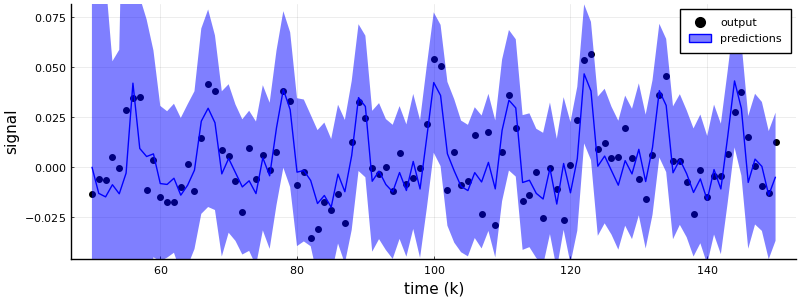

In [12]:
if (ts-tt) > 300
    scatter(tt:tt+300, output[tt:tt+300], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:tt+300, predictions_FEM[1][tt:tt+300], ribbon=[sqrt.(predictions_FEM[2][tt:tt+300]), sqrt.(predictions_FEM[2][tt:tt+300])], color="blue", label="predictions")
else
    scatter(tt:ts, output[tt:ts], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:ts, predictions_FEM[1][tt:ts], ribbon=[sqrt.(predictions_FEM[2][tt:ts]), sqrt.(predictions_FEM[2][tt:ts])], color="blue", label="predictions")
end

## Simulation

In [13]:
# Prepare array
simulations_FEM = (zeros(T,), zeros(T,))
simulations_FEM[1][1:ts] = output[1:ts]

@showprogress for k in ts:T
    
    # Update history vectors
    x_kmin1 = simulations_FEM[1][k-1:-1:k-M1]
    z_kmin1 = input[k-1:-1:k-M2]
    r_kmin1 = zeros(M3,)
    
    # Apply basis function
    ϕx = ϕ([x_kmin1; input[k]; z_kmin1; r_kmin1])
    
    # Predictions
    simulations_FEM[1][k] = θ_k[1]'*ϕx
    simulations_FEM[2][k] = ϕx'*θ_k[2]'*ϕx + inv(τ_k[1]/τ_k[2])
    
end

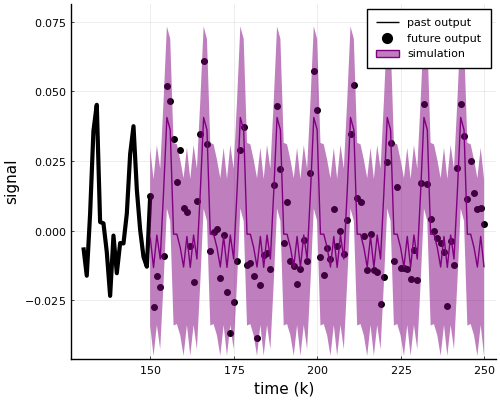

In [14]:
past = 20
ylims=[minimum(output[tt:T]), maximum(output[tt:T])]
plot(ts-past:ts, output[ts-past:ts], color="black", linewidth=3, label="past output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(500,400))

if T-ts > 100
    scatter!(ts:ts+100, output[ts:ts+100], color="black", label="future output", xlabel="time (k)", ylabel="signal")
    plot!(ts:ts+100, simulations_FEM[1][ts:ts+100], ribbon=[sqrt.(simulations_FEM[2][ts:ts+100]), sqrt.(simulations_FEM[2][ts:ts+100])], color="purple", label="simulation")
else
    scatter!(ts:T, output[ts:T], color="black", label="future output", xlabel="time (k)", ylabel="signal")
    plot!(ts:T, simulations_FEM[1][ts:T], ribbon=[sqrt.(simulations_FEM[2][ts:T]), sqrt.(simulations_FEM[2][ts:T])], color="purple", label="simulation")
end

In [15]:
savefig("figures/NARMAX-simulation_deg"*string(deg_m)*"_FEM.png")

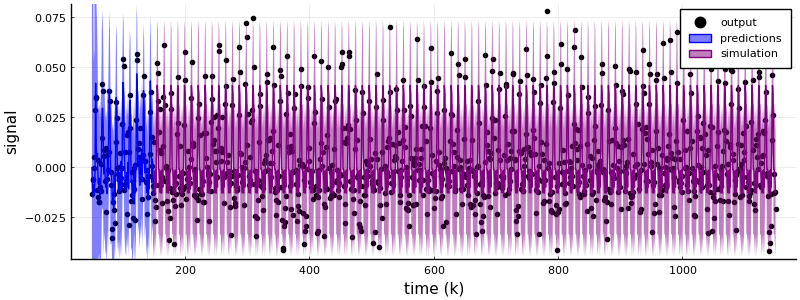

In [16]:
# Full signal
ylims=[minimum(output[tt:T]), maximum(output[tt:T])]
scatter(tt:T, output[tt:T], color="black", markersize=3, label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
plot!(tt:ts, predictions_FEM[1][tt:ts], ribbon=[sqrt.(predictions_FEM[2][tt:ts]), sqrt.(predictions_FEM[2][tt:ts])], color="blue", label="predictions")
plot!(ts:T, simulations_FEM[1][ts:T], ribbon=[sqrt.(simulations_FEM[2][ts:T]), sqrt.(simulations_FEM[2][ts:T])], color="purple", label="simulation")

In [17]:
savefig("figures/NARMAX-fullsignal_deg"*string(deg_m)*"_FEM.png")

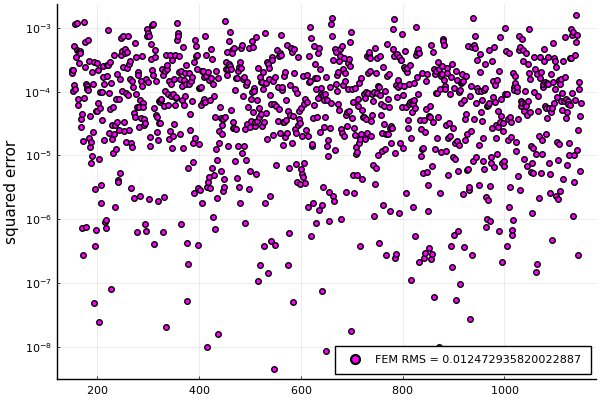

In [18]:
sqerror_FEM = (simulations_FEM[1][ts:T] - output[ts:T]).^2
RMS_FEM = sqrt(mean(sqerror_FEM))

scatter(ts:T, sqerror_FEM, label="FEM RMS = "*string(RMS_FEM), color="magenta", ylabel="squared error", yscale=:log10)

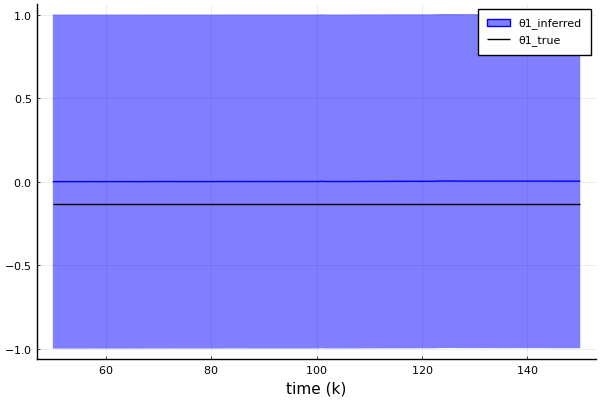

In [19]:
plot(tt:ts, params_θ[1][:,1], ribbon=[sqrt.(params_θ[2][:,1,1]) sqrt.(params_θ[2][:,1,1])], color="blue", xlabel="time (k)", label="θ1_inferred")
plot!(tt:ts, θ_true[1]*ones(ts-tt+1,), color="black", label="θ1_true")

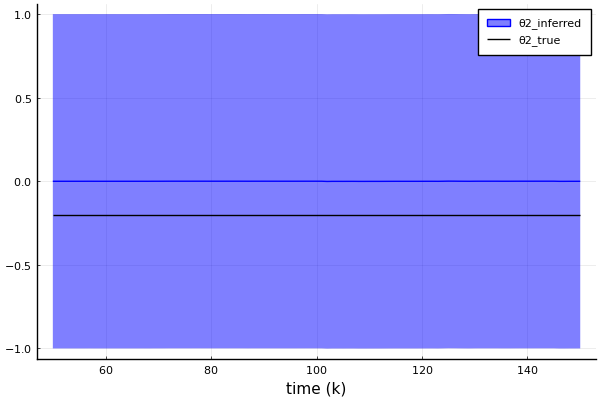

In [20]:
plot(tt:ts, params_θ[1][:,2], ribbon=[sqrt.(params_θ[2][:,2,2]) sqrt.(params_θ[2][:,2,2])], color="blue", xlabel="time (k)", label="θ2_inferred")
plot!(tt:ts, θ_true[2]*ones(ts-tt+1,), color="black", label="θ2_true")

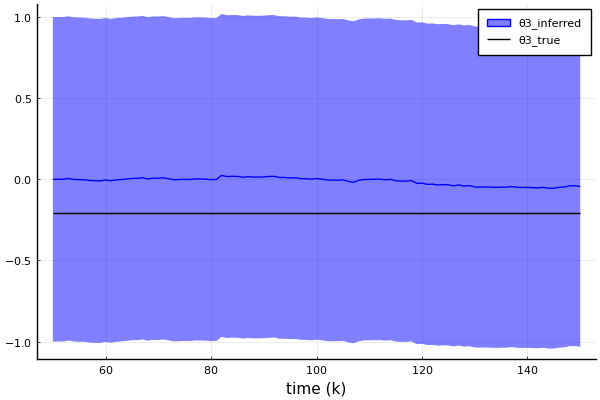

In [21]:
plot(tt:ts, params_θ[1][:,3], ribbon=[sqrt.(params_θ[2][:,3,3]) sqrt.(params_θ[2][:,3,3])], color="blue", xlabel="time (k)", label="θ3_inferred")
plot!(tt:ts, θ_true[3]*ones(ts-tt+1,), color="black", label="θ3_true")

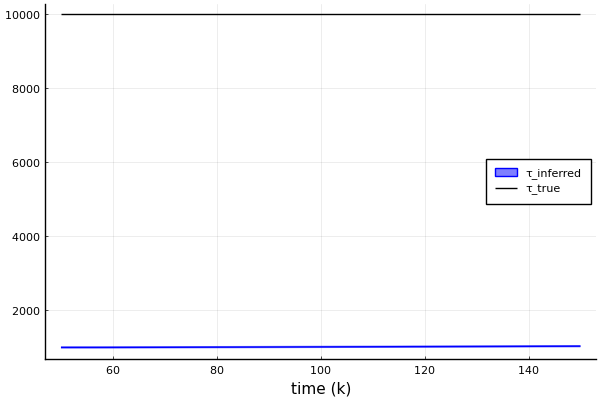

In [22]:
mτ = params_τ[1] ./ params_τ[2]
vτ = params_τ[1] ./ params_τ[2].^2

plot(tt:ts, mτ, ribbon=[sqrt.(vτ) sqrt.(vτ)], color="blue", xlabel="time (k)", label="τ_inferred")
plot!(tt:ts, τ_true*ones(ts-tt+1,), color="black", label="τ_true")

## Baseline: RLS

Recursive least-squares estimator ([wiki](https://en.wikipedia.org/wiki/Recursive_least_squares_filter#Recursive_algorithm)).

In [23]:
# Parameters
λ = 0.98
P = λ.*Matrix{Float64}(I,N_m,N_m)
w_k = zeros(N_m,)
w = zeros(T,N_m)

# Preallocate prediction array
predictions_RLS = zeros(T,)
residuals = zeros(T,)

for k in tt:ts

    # Update data vector
    ϕx = ϕ([output[k-1:-1:k-M1]; input[k:-1:k-M2]; residuals[k-1:-1:k-M3]])

    # Update weights
    α = output[k] - w_k'*ϕx 
    g = P*ϕx*inv(λ + ϕx'*P*ϕx)
    P = inv(λ)*P - g*ϕx'*inv(λ)*P
    w_k = w_k + α*g

    # Prediction
    predictions_RLS[k] = w_k'*ϕx
    residuals[k] = output[k] - predictions_RLS[k]
    
    # Track weights
    w[k,:] = w_k

end

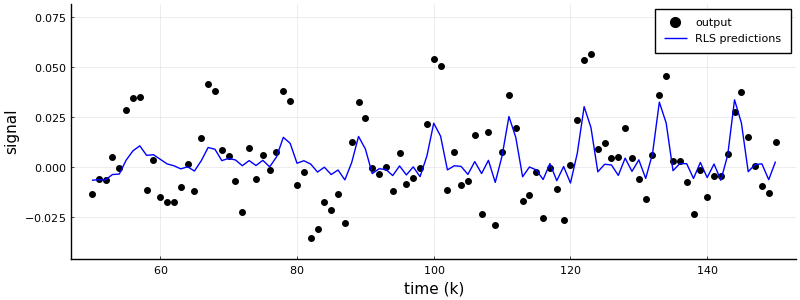

In [24]:
if (ts-tt) > 300
    scatter(tt:tt+300, output[tt:tt+300], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:tt+300, predictions_RLS[tt:tt+300], color="blue", label="RLS predictions")
else
    scatter(tt:ts, output[tt:ts], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(tt:ts, predictions_RLS[tt:ts], color="blue", label="RLS predictions")
end

In [25]:
# Prepare array
simulations_RLS = zeros(T,)
simulations_RLS[1:ts] = output[1:ts]

# Simulation
for k in ts:T
    
    # Update data vector
    ϕx = ϕ([simulations_RLS[k-1:-1:k-M1]; input[k:-1:k-M2]; zeros(M3,)])
    
    # Prediction
    simulations_RLS[k] = w_k'*ϕx
    
end

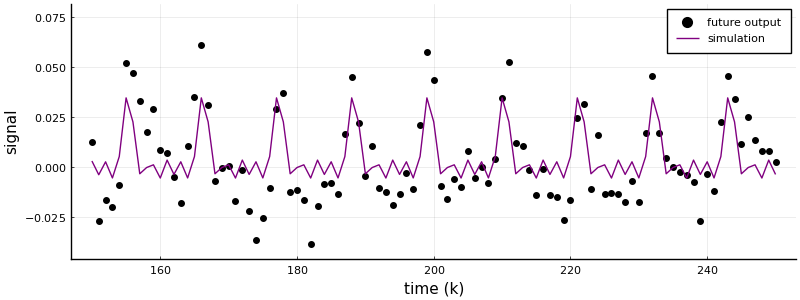

In [26]:
if (T-ts) > 100
    scatter(ts:ts+100, output[ts:ts+100], color="black", label="future output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(ts:ts+100, simulations_RLS[ts:ts+100], color="purple", label="simulation")
else
    scatter(ts:T, output[ts:T], color="black", label="output", xlabel="time (k)", ylabel="signal", ylims=ylims, size=(800,300))
    plot!(ts:T, simulations_RLS[ts:T], color="purple", label="simulation")
end

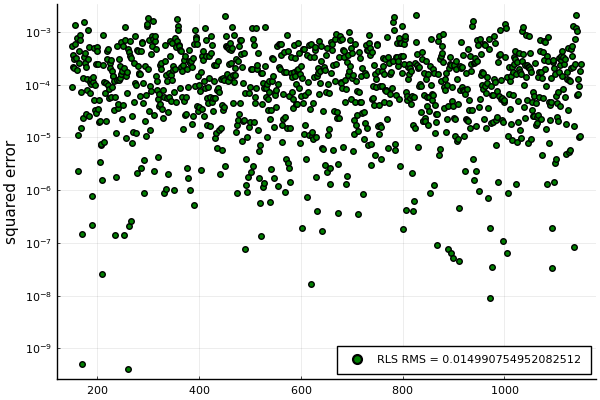

In [27]:
sqerror_RLS = (simulations_RLS[ts:T] - output[ts:T]).^2
RMS_RLS = sqrt(mean(sqerror_RLS))

scatter(ts:T, sqerror_RLS, label="RLS RMS = "*string(RMS_RLS), color="green", ylabel="squared error", yscale=:log10)

## Comparison

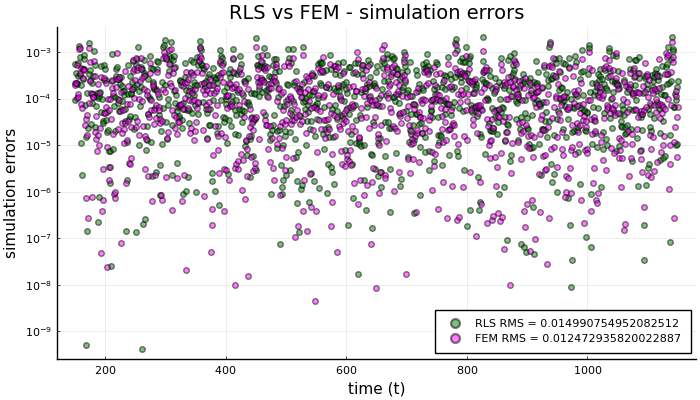

In [28]:
# Comparing simulation errors between PEM and FEM
scatter(ts:T, 
        sqerror_RLS, 
        color="green", 
        alpha=0.5,
        markersize=4, 
        size=(700,400), 
        yscale=:log10,
        xlabel="time (t)", 
        ylabel="simulation errors",
        label="RLS RMS = "*string(RMS_RLS))
scatter!(ts:T, 
         sqerror_FEM, 
         color="magenta", 
         alpha=0.5,
         markersize=4,
         labels="FEM RMS = "*string(RMS_FEM),
         title="RLS vs FEM - simulation errors")

In [29]:
prop_beaten = mean(sqerror_FEM .< sqerror_RLS)
println("Proportion FEM < RLS = "*string(round(prop_beaten*100))*"%")

Proportion FEM < RLS = 65.0%
